# Analysis of Pitchfork album reviews and song lyrics
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import time
import os

FS = 16 # fontsize
%matplotlib inline
plt.style.use('seaborn')

### Load the Pitchfork reviews and song lyrics

In [2]:
# Pitchfork album reviews
reviews = pd.read_json('./data/pitchfork_reviews_matched.json')
reviews = reviews[['artist', 'album', 'year', 'genre',
                   'gender', 'score', 'best_new_music',
                   'abstract', 'editorial', 'label', 'url', 'cover']]

In [3]:
reviews.head(2)

,artist,album,year,genre,gender,score,best_new_music,abstract,editorial,label,url,cover
0,Kanye West,Graduation,2007,rap,male,8.7,1,Though it doesn't quite match\n ...,While rap music famously thrives on the kind o...,Roc-A-Fella\n / \n ...,/reviews/albums/10658-graduation/,https://media.pitchfork.com/photos/5929b270ea9...
1,Kanye West,Late Registration,2005,rap,male,9.5,1,The producer-rapper follows his Pazz and Jop-w...,"""Can I talk my shit again?""\n ...",Roc-A-Fella\n / \n ...,/reviews/albums/8768-late-registration/,https://media.pitchfork.com/photos/5929aa8db13...


In [4]:
# Load the song lyrics
songs = pd.read_json('./data/songs_with_reviews.json')
songs = songs[['title', 'artist', 'album', 'year', 'genre',
               'gender', 'lyrics', 'image']]

In [5]:
songs.head(2)

,title,artist,album,year,genre,gender,lyrics,image
0,2 of Amerikaz Most Wanted,2Pac,All Eyez on Me,1996-05-07,rap,male,Up out of there\nAin't nothin' but a gangsta p...,https://images.genius.com/e47c72fcb1f2756daafc...
1,Ain't Hard 2 Find,2Pac,All Eyez on Me,1996-02-13,rap,male,"They say\nInfluenced by crime, addicted to gri...",https://images.genius.com/e47c72fcb1f2756daafc...


# Exploratory analysis

### How many reviews do we have for each artist?

In [6]:
artists = reviews.groupby('artist')

Total number of artists: 121
Total number of reviews: 532
Median of 3 reviews per artist.


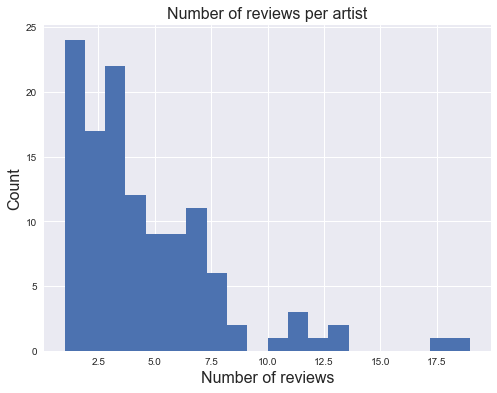

In [7]:
print("Total number of artists: {}".format(len(artists)))
print("Total number of reviews: {}".format(len(reviews)))
print("Median of {:1.0f} reviews per artist.".format(np.median(artists.count())))

# Histogram of the number of reviews per artist
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(artists.count()['album'], 20)
ax.set_xlabel("Number of reviews", fontsize=FS)
ax.set_ylabel("Count", fontsize=FS)
ax.set_title("Number of reviews per artist", fontsize=FS)
plt.show()

## Pitchfork reviews over time

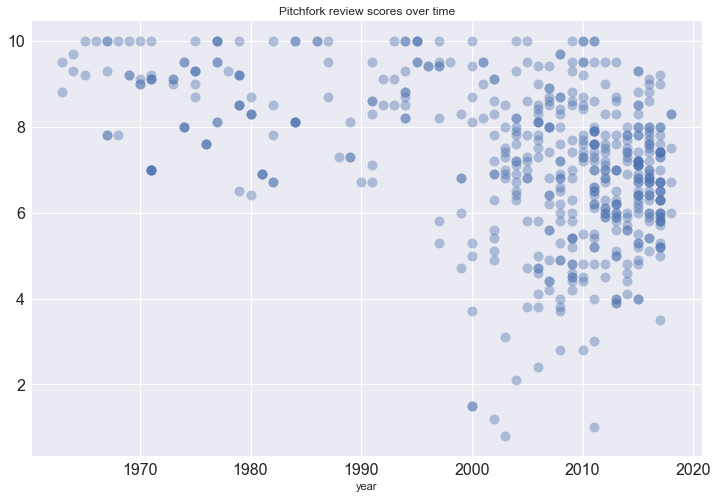

In [71]:
params = {'alpha': 0.4, 'title': 'Pitchfork review scores over time', 'figsize': (12, 8),
          'linestyle': '', 'marker': 'o', 'ms': 10, 'fontsize': FS, 'legend': False}
reviews.plot(x='year', y='score', kind='line', **params)

In [78]:
years = reviews.groupby('year')
years.mean().head()

,score,best_new_music
year,,
1963,9.15,0.0
1964,9.50,0.0
1965,9.60,0.0
1966,10.00,0.0
1967,8.98,0.0


## Pitchfork review scores separated by gender

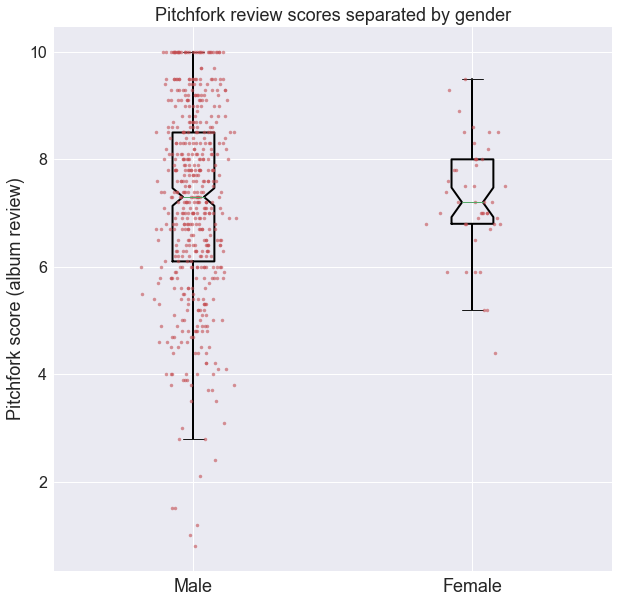

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
boxprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='-',linewidth=2.0, color='black')
ax.boxplot(scores_by_gender, boxprops=boxprops, whiskerprops=whiskerprops, showfliers=False, notch=True)
for i,y in enumerate(scores_by_gender):
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.06, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.6)

# Touch up the plot
# ax.set_xlabel("Artist gender", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.set_xticklabels(["Male","Female"], fontsize=FS)
ax.set_title("Pitchfork review scores separated by gender", fontsize=FS)
plt.show()

In [14]:
# List of all albums with a ratio of 10
# album_names[album_scores==10]

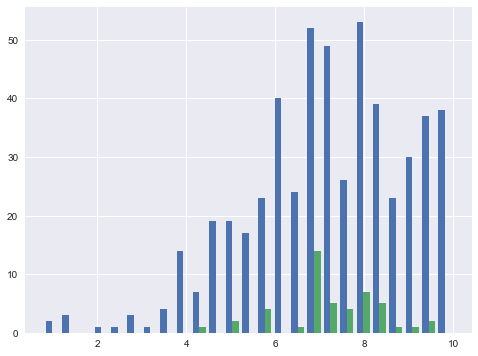

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(scores_by_gender, 25)
plt.show()

## Interactive plot that shows review abstract with mouse over

In [16]:
# Album cover should pop up

## Pitchfork Review scores as a function of lexical diversity

In [17]:
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def lexdiv(s):
    try:
        words = clean_str(s).split(' ')
        return len(set(words))/len(words)
    except:
        return 0

In [18]:
# Calculate lexical diversity for each album
album_lexdivs, album_scores, album_names, album_genders = [],[],[],[]
album_artists, album_imgs, album_genres, album_years = [],[],[],[]
for artist in artists:
    reviews_for_artist = all_reviews[artist['artist']]
    reviews_by_searched_name = dict(zip([review.searched_album for review in all_reviews[artist['artist']]], all_reviews[artist['artist']]))
    artist_album_names = [review.searched_album for review in reviews_for_artist]
    
    # Group together lyrics by album
    albums = {}
    for song in artist['songs']:
        album = song['album']
        if album in artist_album_names:
            if album in albums:
                albums[album] += song['lyrics']
            else:
                albums[album] = song['lyrics']
                
    # Calculate each albums' lexical diversity
    for album, lyrics in albums.items():        
        # Lexical diversity, Pitchfork score, and album name
        album_lexdivs.append(lexdiv(lyrics))
        album_scores.append(reviews_by_searched_name[album].score())
        album_names.append(reviews_by_searched_name[album].album())
        album_genders.append('male') if artist['gender'] == 'male' else album_genders.append('female')
        album_artists.append(artist['artist'])
        album_imgs.append(reviews_by_searched_name[album].cover())
        album_genres.append(artist['genre'])
        album_years.append(reviews_by_searched_name[album].year())
        
# numpy
# I guess these should all really just be columns in a dataframe
album_lexdivs = np.array(album_lexdivs)
album_scores = np.array(album_scores)
album_names = np.array(album_names)
album_genders = np.array(album_genders)
album_artists = np.array(album_artists)
album_imgs = np.array(album_imgs)
album_genres = np.array(album_genres)
album_years = np.array(album_years)

In [19]:
%matplotlib inline
mpld3.enable_notebook()

# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: center;
}
img
{
    border-radius: 8px;
    height: auto;        
}
center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
"""

In [28]:
# Create the data tips
df = pd.DataFrame({'album': album_names, 'year': album_years, 'genre': album_genres, 'gender': album_genders,
                   'score': album_scores, 'lexdiv': album_lexdivs})
names = album_artists
imgs = ['<img src="{}" width="80">'.format(url) for url in album_imgs]
labels = []
for i in range(len(df)):
    label = df.iloc[[i], :].T    
    label.columns = [names[i]]
    html = label.drop([], axis=0).to_html() + '\n' + imgs[i]
    labels.append(html)

# --------------------------
# Do the actual plotting
# Scatter plot the data
ms = 9
fig, ax = plt.subplots(figsize=(10,8))
ax.grid(True, alpha=0.3)

x,y = album_lexdivs, album_scores
b = []
for genre, color in zip(['rap', 'rock', 'country'],['r','g','b']):
    b.append(plt.plot(x[album_genres==genre], y[album_genres==genre], color+'o', ms=ms, alpha=0.7, label=genre))

# https://mpld3.github.io/examples/html_tooltips.html
points = ax.plot(df['lexdiv'], df['score'], 'ko', mec='k', ms=ms, alpha=0.0, label="") # Plot all of the data
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

ax.set_xlabel("Lexical diversity (album lyrics)", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
ax.annotate("@johnwmillr", (0.17,1), fontsize=FS-4, alpha=0.5)
ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)

mpld3.display()
# plotname = 'mpld3_{}_vs_{}'.format('lexdiv','score')
# mpld3.save_html(fig, './figures/'+plotname+'.html', figid=plotname, template_type='simple')

In [199]:
all_reviews['Radiohead'][0]

Review('Radiohead', 'In Rainbows', 'Radiohead', 'In Rainbows [CD 2]', 'Radiohead%20In%20Rainbows', '/reviews/albums/10988-in-rainbows-cd-2/', "<class 'bs4.BeautifulSoup'>")

In [182]:
print(all_reviews['Pink Floyd'][-1].score())
print(all_reviews['Pink Floyd'][-1].cover())

5.7
https://media.pitchfork.com/photos/5929ab319d034d5c69bf3fa2/1:1/w_320/a143963d.jpg


In [183]:
print(all_reviews['Nirvana'][-1].score())
print(all_reviews['Nirvana'][-1].cover())

10.0
https://media.pitchfork.com/photos/5929b123c0084474cd0c1d7a/1:1/w_320/27425f15.jpg


In [172]:
album_names[np.logical_and(album_scores < 6, album_lexdivs > 0.5)]

array(['The Endless River'], dtype='<U53')

TypeError: Object of type 'ndarray' is not JSON serializable

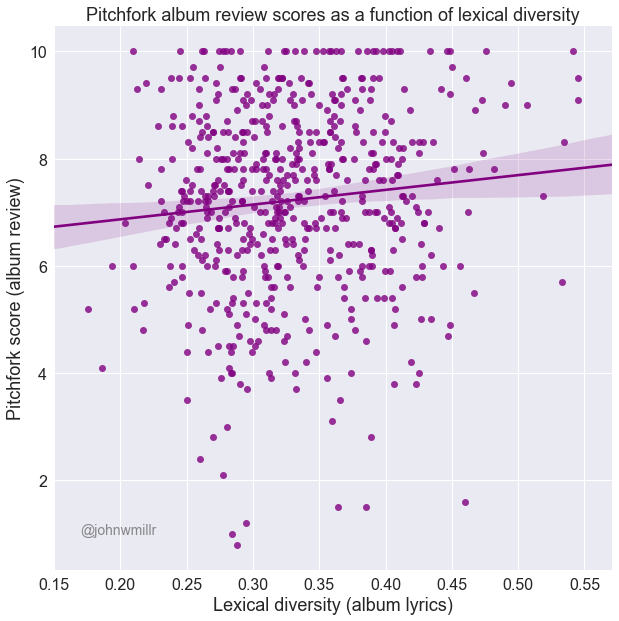

In [207]:
# Plot review score as a function of lexical diversity
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x=album_lexdivs, y=album_scores, ax=ax, color='purple', label='Album')
ax.set_xlabel("Lexical diversity (album lyrics)", fontsize=FS)
ax.set_ylabel("Pitchfork score (album review)", fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
ax.annotate("@johnwmillr", (0.17,1), fontsize=FS-4, alpha=0.5)
# ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)
# fig.savefig("./figures/pitchfork_score_vs_lexdiv_v2.png", format="png", dpi=300, bbox_inches="tight")
plt.show()